# SRCNN (Super-resolution CNN)

<br>
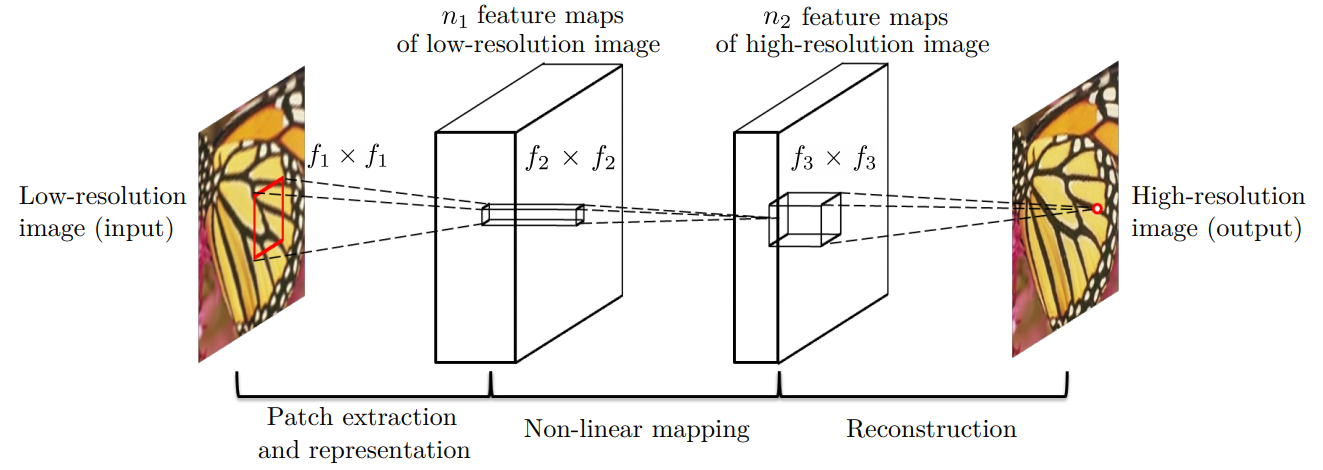


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import zipfile

zip_path1 = '/content/drive/MyDrive/Colab Notebooks/2025_1 딥러닝/t91.zip'
zip_path2 = '/content/drive/MyDrive/Colab Notebooks/2025_1 딥러닝/Set5.zip'

extract_path1 = './t91'
extract_path2 = './Set5'

# 압축 해제
if not os.path.exists(extract_path1):
    with zipfile.ZipFile(zip_path1, 'r') as zip_ref:
        zip_ref.extractall(extract_path1)
else:
    print("Already extracted")

if not os.path.exists(extract_path2):
    with zipfile.ZipFile(zip_path2, 'r') as zip_ref:
        zip_ref.extractall(extract_path2)
else:
    print("Already extracted")

### Dataset 전처리

1. 고해상도 이미지(원본 이미지)를 Down-sampling한 후 Up-sampling하여 저해상도 이미지를 생성
2. Crop으로 저해상도 이미지, 고해상도 이미지에서 여러 개의 패치 추출
3. 저해상도 패치(Input), 고해상도 패치(Target)로 학습

In [ ]:
import os
import glob
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision.transforms.functional import to_tensor, to_pil_image

class CustomDataset(Dataset):
    def __init__(self, img_dir, patch_size=33, stride=14, scale=2):
        self.input_patches = []
        self.target_patches = []

        image_paths = sorted(glob.glob(os.path.join(img_dir, '*.png'))) # img_dir의 모든 png 파일 path

        # hr: high resolution, lr: low resolution
        for path in image_paths:
            hr_img = Image.open(path).convert('RGB')
            w, h = hr_img.size

            lr_img = hr_img.resize((w // scale, h // scale), Image.BICUBIC) # Down-sampling (BICUBIC은 건들지 않는다!!)
            lr_up_img = lr_img.resize((w, h), Image.BICUBIC) # Up-sampling

            # Patch extraction
            # 작은 패치로 나눠서 학습하는 것이 더 학습이 빠르고 성능이 좋음
            for top in range(0, h - patch_size + 1, stride):
                for left in range(0, w - patch_size + 1, stride):
                    hr_patch = hr_img.crop((left, top, left + patch_size, top + patch_size))
                    lr_patch = lr_up_img.crop((left, top, left + patch_size, top + patch_size))

                    input = to_tensor(lr_patch) # to_tensor: numpy or PILImage -> tensor
                    target = to_tensor(hr_patch)

                    self.input_patches.append(input)
                    self.target_patches.append(target)

    def __len__(self):
        return len(self.input_patches) # 전체 데이터셋 크기 반환

    def __getitem__(self, idx):
        return self.input_patches[idx], self.target_patches[idx] # 각 인덱스에 해당하는 (Input, Target) 샘플 반환

# dataset
trainset = CustomDataset(img_dir='./t91', patch_size=33, stride=14, scale=2)

print(f"# of trainset = {len(trainset)}")

input, target = trainset[0]
print(f"input size: {input.shape}, target size: {target.shape}")

# dataloader
batchsize = 128

trainloader = torch.utils.data.DataLoader(trainset,
                                          batch_size=batchsize,
                                          shuffle=True,
                                          num_workers=2,
                                          drop_last=True)

# of trainset = 22092
input size: torch.Size([3, 33, 33]), target size: torch.Size([3, 33, 33])


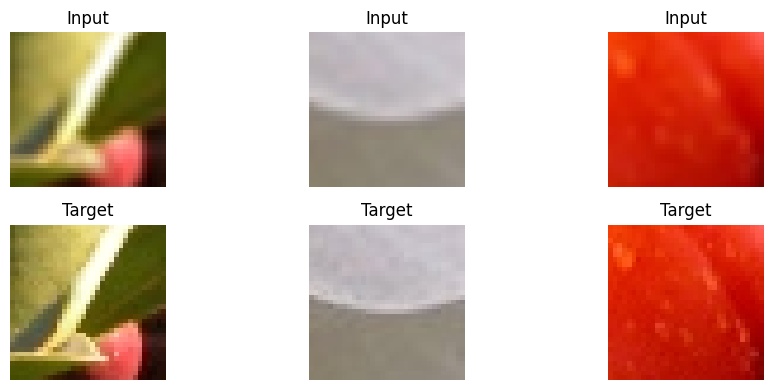

In [ ]:
import matplotlib.pyplot as plt
import random

indices = random.sample(range(len(trainset)), 3)

plt.figure(figsize=(10, 4))

for i, idx in enumerate(indices):
    data, label = trainset[idx]

    plt.subplot(2, 3, i + 1)
    plt.imshow(to_pil_image(data)) # to_pil_image: tensor or numpy -> PIL Image
    plt.title("Input")
    plt.axis("off")

    plt.subplot(2, 3, i + 4)
    plt.imshow(to_pil_image(label))
    plt.title("Target")
    plt.axis("off")

plt.tight_layout()
plt.show()

# Model 정의
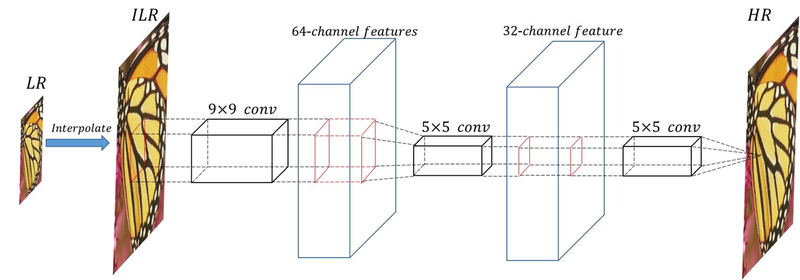


In [ ]:
import torch.nn as nn

class SRCNN(nn.Module):
    def __init__(self):
        super(SRCNN, self).__init__()

        # 입력과 동일한 크기 출력 -> padding = (kernel_size - 1) / 2
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=9, padding=4), # 3 input channel, 64 output channel, 9x9 conv---여기서부터는 파라미터를 맘대로 조절
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=5, padding=2), # 64 input channel, 32 output channel, 5x5 conv
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 3, kernel_size=5, padding=2) # 32 input channel, 3 output channel, 5x5 conv
        )

    def forward(self, x):
        x = self.model(x)
        return x.clamp(0,1) # 출력 [0,1]--최소:0 / 최대:1 프로젝트에서는 그대로 사용 sigmoid대신 사용하는 이유(sigmoid는 1에 가까워지면 학습이 멈춤)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device : ", device)

model = SRCNN().to(device)

device :  cuda


In [ ]:
!pip install torchinfo -qq

In [ ]:
from torchinfo import summary # model 구조, 파라미터 수, 출력 크기 등 정보

summary(model, (10, 3, 33, 33)) # (batch, C, H, W)

Layer (type:depth-idx)                   Output Shape              Param #
SRCNN                                    [10, 3, 33, 33]           --
├─Sequential: 1-1                        [10, 3, 33, 33]           --
│    └─Conv2d: 2-1                       [10, 64, 33, 33]          15,616
│    └─ReLU: 2-2                         [10, 64, 33, 33]          --
│    └─Conv2d: 2-3                       [10, 32, 33, 33]          51,232
│    └─ReLU: 2-4                         [10, 32, 33, 33]          --
│    └─Conv2d: 2-5                       [10, 3, 33, 33]           2,403
Total params: 69,251
Trainable params: 69,251
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 754.14
Input size (MB): 0.13
Forward/backward pass size (MB): 8.62
Params size (MB): 0.28
Estimated Total Size (MB): 9.03

# 학습

In [ ]:
import torch.optim as optim
from tqdm.notebook import tqdm
import numpy as np

def train(model, device, train_loader, optimizer, criterion, num_epochs, scheduler = None):

    history = np.zeros((0,2)) # loss 저장 변수

    model.train() # train mode로 선언

    for epoch in tqdm(range(num_epochs)):
        epoch_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            outputs = model(inputs) # 모델에 입력
            loss = criterion(outputs, targets) # loss 계산(MSE)

            optimizer.zero_grad() # gradient 초기화
            loss.backward() # gradient 계산
            optimizer.step() # parameter update

            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(train_loader)

        item = np.array([epoch+1, avg_loss])

        history = np.vstack((history, item))

        if scheduler is not None:
            scheduler.step()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

    return history

model = SRCNN().to(device)

# optimizer
learning_rate = 1e-3
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# shceduler(learning rate 조절)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=40, gamma=0.1) # 40 epoch마다 0.1배

# loss fuction(MSE)
criterion = nn.MSELoss()

num_epochs = 50

history = train(model, device, trainloader, optimizer, criterion, num_epochs, scheduler)

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/50], Loss: 0.010545
Epoch [2/50], Loss: 0.002130
Epoch [3/50], Loss: 0.001760
Epoch [4/50], Loss: 0.001627
Epoch [5/50], Loss: 0.001464
Epoch [6/50], Loss: 0.001464
Epoch [7/50], Loss: 0.001448
Epoch [8/50], Loss: 0.001294
Epoch [9/50], Loss: 0.001252
Epoch [10/50], Loss: 0.001308
Epoch [11/50], Loss: 0.001249
Epoch [12/50], Loss: 0.001219
Epoch [13/50], Loss: 0.001213
Epoch [14/50], Loss: 0.001404
Epoch [15/50], Loss: 0.001112
Epoch [16/50], Loss: 0.001170
Epoch [17/50], Loss: 0.001176
Epoch [18/50], Loss: 0.001151
Epoch [19/50], Loss: 0.001148
Epoch [20/50], Loss: 0.001117
Epoch [21/50], Loss: 0.001132
Epoch [22/50], Loss: 0.001149
Epoch [23/50], Loss: 0.001128
Epoch [24/50], Loss: 0.001094
Epoch [25/50], Loss: 0.001143
Epoch [26/50], Loss: 0.001123
Epoch [27/50], Loss: 0.001096
Epoch [28/50], Loss: 0.001071
Epoch [29/50], Loss: 0.001117
Epoch [30/50], Loss: 0.001064
Epoch [31/50], Loss: 0.001060
Epoch [32/50], Loss: 0.001103
Epoch [33/50], Loss: 0.001038
Epoch [34/50], Loss

initial state : loss : 0.01054
final state : loss : 0.00095


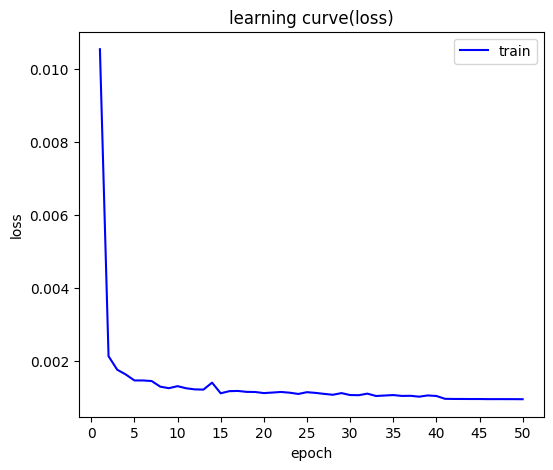

In [ ]:
print(f'initial state : loss : {history[0,1]:.5f}')
print(f'final state : loss : {history[-1,1]:.5f}')

num_epochs = len(history)
unit = num_epochs / 10

plt.figure(figsize=(6,5))
plt.plot(history[:,0], history[:,1], 'b', label='train')
plt.xticks(np.arange(0,num_epochs+1, unit))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('learning curve(loss)')
plt.legend()
plt.show()

## Inference

In [ ]:
hr = Image.open('./Set5/butterfly.png').convert('RGB') # Test data(baby, bird, butterfly, head, woman)
w, h = hr.size

# Down-sampling, Up-sampling
lr = hr.resize((w // 2, h // 2), Image.BICUBIC)
lr_up = lr.resize((w, h), Image.BICUBIC)

In [ ]:
model.eval() # test mode로 선언

lr_up_tensor = to_tensor(lr_up) # PILImage -> tensor
lr_up_tensor = lr_up_tensor.unsqueeze(0) # batch 차원 추가(CxHxW -> 1xCxHxW)
lr_up_tensor = lr_up_tensor.to(device)

with torch.no_grad(): # gradient 계산 비활성화(메모리 절약, 연산 속도 향상)
  output = model(lr_up_tensor).squeeze() # inference

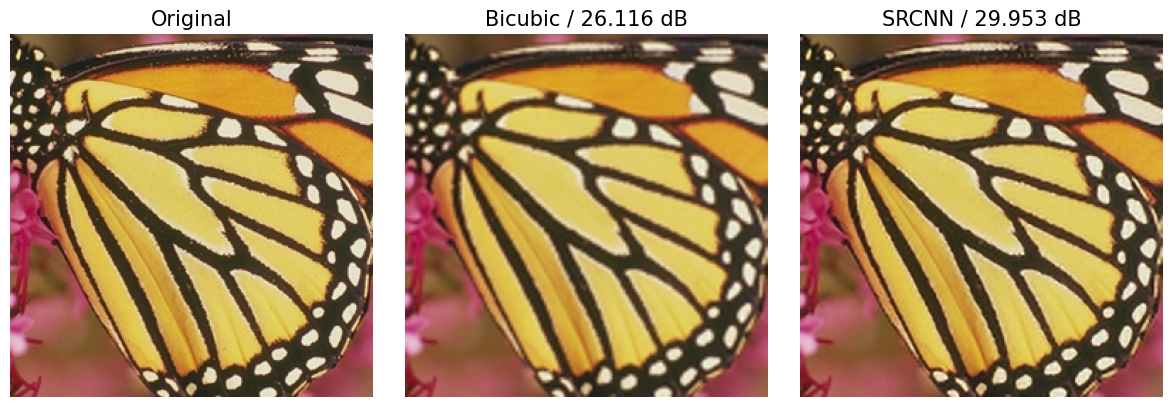

In [ ]:
def compute_psnr(x1, x2):
    mse = torch.mean((x1 - x2) ** 2)
    psnr = 10 * torch.log10(1.0 / (mse + 1e-8))
    return psnr

# psnr 계산
psnr_bicubic = compute_psnr(to_tensor(hr), to_tensor(lr_up))
psnr_srcnn = compute_psnr(to_tensor(hr), output.cpu())

# plot
plt.figure(figsize=(12,4))

plt.subplot(1, 3, 1)
plt.imshow(hr)
plt.title("Original", fontsize = 15)
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(lr_up)
plt.title(f"Bicubic / {psnr_bicubic:.3f} dB", fontsize = 15)
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(to_pil_image(output))
plt.title(f"SRCNN / {psnr_srcnn:.3f} dB", fontsize = 15)
plt.axis("off")

plt.tight_layout()
plt.show()